In [1]:
import os, sys
os.environ['ON_PY']="1"
from params import parser
from common_utils import setup_seed
from data_utils import pack_data_from_config
import numpy as np
from test_script.base import Test
import matplotlib.pyplot as plt
import numpy as np

notebook_dir = os.getcwd()
print(notebook_dir)
# 将工作目录更改为上一级目录
os.chdir("/home/wlc/FJSP-DRL-MAML")



(CVXPY) Aug 22 05:23:06 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 22 05:23:06 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


/home/wlc/FJSP-DRL-MAML/plot_imgs


In [2]:
instances = [ "10x5EC+ECMK", "20x5EC+ECMK", "15x10EC+ECMK", "20x10EC+ECMK", ]
test_data_list = [ "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",]


In [3]:


args = ["--test_data", *test_data_list,
        "--test_model", *instances]

ec_args = ["--fea_j_input_dim", "16", 
    "--fea_m_input_dim", "11",
    '--factor_Mk', "0.8",
    '--factor_Ec', "0.2", 
    "--model_source", "SD2EC0",
    "--data_source", "SD2EC0",
    "--lr", "3e-4",
    ]

args = [*ec_args, *args]

print(args)


['--fea_j_input_dim', '16', '--fea_m_input_dim', '11', '--factor_Mk', '0.8', '--factor_Ec', '0.2', '--model_source', 'SD2EC0', '--data_source', 'SD2EC0', '--lr', '3e-4', '--test_data', '10x5+mix', '20x5+mix', '15x10+mix', '20x10+mix', '--test_model', '10x5EC+ECMK', '20x5EC+ECMK', '15x10EC+ECMK', '20x10EC+ECMK']


In [4]:
# DAN 解
configs = parser.parse_args(args=args)

setup_seed(configs.seed_test)

test_model = []

for model_name in configs.test_model:
    test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
print(test_model)
test_data = pack_data_from_config(configs.data_source, configs.test_data)

print(os.getcwd())
baseline_makespans = []
baseline_EC = []
for i in range(len(test_model)):
    model = test_model[i]
    data = test_data[i]
    print("datta[1]: ",data[1])
    print("-" * 25 + "Test Learned Model" + "-" * 25)
    print(f"test data name: {data[1]}")
    finetuning = True if model[1].startswith("maml") else False
    print(f"Model name : {model[1]}")
    result_5_times = []
    for j in range(2):
        test = Test(configs, data[0], model[0])     
        result = test.greedy_strategy(finetuning=finetuning)
        result_5_times.append(result)
    result_5_times = np.array(result_5_times)

    save_result = np.min(result_5_times, axis=0)
    print("testing results:")
    print(f"makespan(greedy): ", save_result[:, 0].mean())
    baseline_makespans.append(save_result[:, 0].mean())
    baseline_EC.append(save_result[:, 1].mean())
    # print(f"time: ", save_result[:, 2].mean())
    # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
    # print(f"Average fast_adapt time:", save_result[:, 3].mean())
    print("="*100)

baseline_makespans = np.array(baseline_makespans)
baseline_EC = np.array(baseline_EC)
print(baseline_makespans)
print(baseline_EC)



[('./trained_network/SD2EC0/10x5EC+ECMK.pth', '10x5EC+ECMK'), ('./trained_network/SD2EC0/20x5EC+ECMK.pth', '20x5EC+ECMK'), ('./trained_network/SD2EC0/15x10EC+ECMK.pth', '15x10EC+ECMK'), ('./trained_network/SD2EC0/20x10EC+ECMK.pth', '20x10EC+ECMK')]
/home/wlc/FJSP-DRL-MAML
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : 10x5EC+ECMK


In [ ]:
# MAML finetuning
# 获取finetuning的每个过程

def MAML_finetuning_test(args):
    configs = parser.parse_args(args=args)
    # print(configs.hidden_dim_actor, configs.hidden_dim_critic)
    test_model = []
    for model_name in configs.test_model:
        test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
    print(test_model)

    model = test_model[0]

    test_data = pack_data_from_config(configs.data_source, configs.test_data)

    makespans = []
    finetuning_makespans = []
    finetuning_ecs = []
    for data in test_data:
        ### 对每个实例
        print("datta[1]: ",data[1])
        print("-" * 25 + "Test Learned Model" + "-" * 25)
        print(f"test data name: {data[1]}")
        if model[1].startswith("maml"): finetuning = True
        print(f"Model name : {model[1]}")
        result_5_times = []
        test = Test(configs, data[0], model[0])
        finetuning_makespan, finetuning_ec = test.finetuning(times=5)
        
        finetuning_makespans.append(finetuning_makespan)
        finetuning_ecs.append(finetuning_ec)

    return finetuning_makespans, finetuning_ecs


In [ ]:
model = "maml+exp18-9"
# model = "maml+exp18-10"
# model = "maml+EXP19maml1707148858" #调整为竞争的工件和机器
# model = "maml+EXP19maml1707189752" #调整训练次数1->4
# model = "maml+EXP19maml1707277364" #只用MAML训练actor
# model = "maml+EXP19maml1708610726" # 内部更新feature_exact
# model = "maml+EXP19maml1709199921" # 缓更新
# model = "maml+EXP19maml1709210851" # adapt_lr=0.01
# model = "maml+EXP19maml1709211969" # adapt_lr=0.001
# model = "maml+EXP19maml1709212192" ## adapt_lr=0.0001
model = "maml+EXP19maml1709367712" # 无缓更新技术
model = "maml+EXP19maml1709693698"  ## feature_exact
model = "maml+EXP19maml1709779578"  # iter 500 + op_per_job=10
model = "maml+EXP19maml1709779197"  # iter = 500 op_per_job=M
model = "maml+EXP19maml1709816607"  ### 缓更新  iter=400
# model = "maml+EXP19maml1710490407"
model = "maml+MAMLECmaml1711335786"
model = "maml+MAMLECmaml1711939372"
model = "maml+MAMLECmaml1712286484"
# model = "maml+MAMLEC1713411967"
model = "maml+MAMLEC1713967388"
model = "maml+MAMLEC1714012487"
model = "maml+MAMLEC1714064946"
model = "maml+MAMLEC1714396849"
model = "maml+MAMLEC1714433927"
# model = "maml+MAMLEC1714985493"
model = "maml+MAMLMK1715170282"
model = "maml+MAMLEC1715261649"
model = "maml+MAMLEC1723516249"

args = [*ec_args, "--test_data", *test_data_list,  "--test_model", model, 
                # "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        ]

maml_finetuning_makespans, maml_finetuning_ecs = MAML_finetuning_test(args)

print(maml_finetuning_makespans)
print(maml_finetuning_ecs)


[('./trained_network/SD2EC0/maml+MAMLEC1723516249.pth', 'maml+MAMLEC1723516249')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+MAMLEC1723516249
[[601.0, 420.0, 570.0, 454.0, 464.0]]
[[12.253379196030485, 8.245365644221591, 10.181347669172887, 9.319606681892004, 10.0031030015755]]


In [ ]:
# pretrain finetuning

args = [*ec_args, "--test_data", *test_data_list, 
        # "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", "PreTrain"]

pretrain_finetuning_makespans, pretrain_finetuning_ecs = MAML_finetuning_test(args)


print(plot_dict)
print(pretrain_finetuning_makespans, pretrain_finetuning_ecs)

[('./trained_network/SD2EC0/maml+MAMLECpre_train1712286401.pth', 'maml+MAMLECpre_train1712286401')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+MAMLECpre_train1712286401


FileNotFoundError: [Errno 2] No such file or directory: './trained_network/SD2EC0/maml+MAMLECpre_train1712286401.pth'

: 

In [ ]:
# random
import torch
from model.PPO import PPO_initialize

ppo = PPO_initialize(configs)

torch.save(ppo.policy.state_dict(), f'./trained_network/SD2EC0/test_random.pth')

args = [*ec_args, "--test_data", *test_data_list, 
        "--test_model", "test_random"]

random_finetuning_makespans, random_finetuning_ecs = MAML_finetuning_test(args)

print(random_finetuning_makespans, random_finetuning_ecs)


In [ ]:
from plot_imgs.plt_utils import plot_funetuning


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


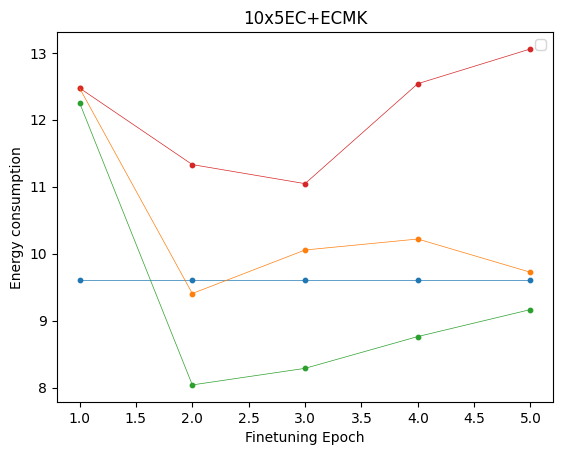

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


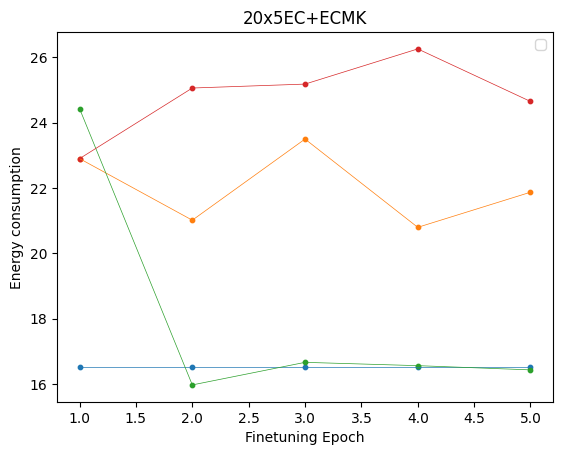

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


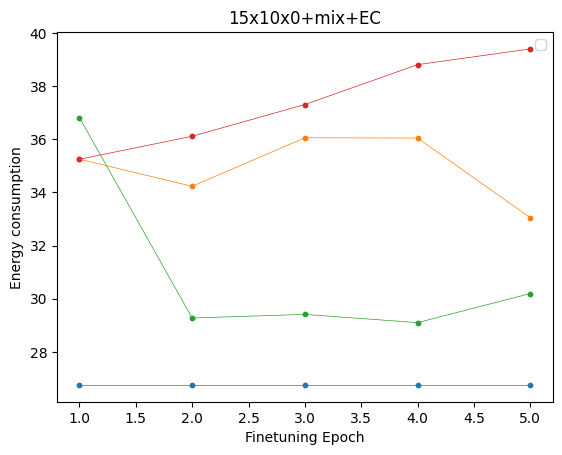

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


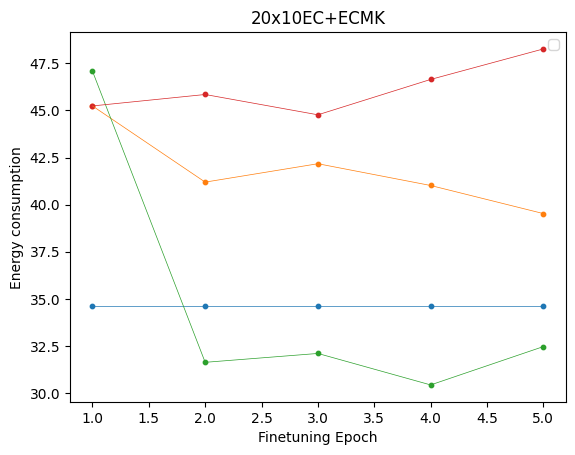

In [ ]:

for idx, key in enumerate(instances):
    # plot_dict[key][0] = [baseline_makespans[idx]  for _ in range(configs.adapt_nums)]
    plot_dict[key][0] = np.full(5, baseline_EC[idx])
    plot_dict[key][1] = maml_finetuning_ecs[idx]
    plot_dict[key][2] = pretrain_finetuning_ecs[idx]
    plot_dict[key][3] = random_finetuning_ecs[idx]
    # plot_makespan_fill(
    #     [np.full(5, baseline_EC[idx]), maml_finetuning_ecs[idx].mean(axis=0), pretrain_finetuning_ecs[idx].mean(axis=0), random_finetuning_ecs[idx].mean(axis=0)],
    #     [np.full(5, baseline_EC[idx]), maml_finetuning_ecs[idx].max(axis=0), pretrain_finetuning_ecs[idx].max(axis=0), random_finetuning_ecs[idx].max(axis=0)],
    #     [np.full(5, baseline_EC[idx]), maml_finetuning_ecs[idx].min(axis=0), pretrain_finetuning_ecs[idx].min(axis=0), random_finetuning_ecs[idx].min(axis=0)],
    #     key,
    # )
    plot_funetuning([np.full(5, baseline_EC[idx]), maml_finetuning_ecs[idx], pretrain_finetuning_ecs[idx], random_finetuning_ecs[idx]], key, y_label="Energy consumption")



In [ ]:
plot_dict

{'10x5EC+ECMK': [array([9.60721719, 9.60721719, 9.60721719, 9.60721719, 9.60721719]),
  [12.474000384421082,
   9.404515682719332,
   10.054535376799727,
   10.218679510449029,
   9.722014414397584],
  [12.253379196030485,
   8.039078834803137,
   8.28674219241998,
   8.761584437401382,
   9.16480884603909],
  [12.474000384421082,
   11.330458091506108,
   11.045815599152245,
   12.539005372224393,
   13.05837387472679]],
 '20x5EC+ECMK': [array([16.51364197, 16.51364197, 16.51364197, 16.51364197, 16.51364197]),
  [22.90153086523137,
   21.016854192942915,
   23.500061068218884,
   20.798444115782697,
   21.872823692724037],
  [24.43044324984268,
   15.975432265358931,
   16.666384147938512,
   16.565116388072347,
   16.43607272749889],
  [22.90153086523137,
   25.061672217678147,
   25.182017406231346,
   26.2584959627625,
   24.651289028420802]],
 '15x10x0+mix+EC': [array([26.75289926, 26.75289926, 26.75289926, 26.75289926, 26.75289926]),
  [35.250804777316226,
   34.23237187978582,
 